# Logistic Regression

An implementation of Logistic Regression from scratch in python using numpy. 

## 0. Importing Numpy and Matplotlib

In [1]:
import sys

# Check what version of Python is running
print (sys.version)

3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


You will need to have [Numpy](http://www.numpy.org/) installed for the version of Python you're using. I highly recommend using [Anaconda](https://conda.io/docs/user-guide/install/index.html) package manager to handle package installs etc.

In [2]:
# Some set up for numpy and matplotlib.

import random
import numpy as np
import matplotlib.pyplot as plt

# To make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Visualizing the data

The provided dataset contains applicants' scores on two exams and corresponding admission decisons. 


# of training examples =  100
# of features =  2


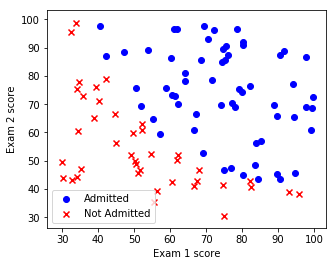

In [3]:
#load the dataset
data = np.loadtxt('data.txt', delimiter=',')

train_X = data[:, 0:2]
train_y = data[:, 2]

# Get the number of training examples and the number of features
m_samples, n_features = train_X.shape
print ("# of training examples = ", m_samples)
print ("# of features = ", n_features)

pos = np.where(train_y == 1)
neg = np.where(train_y == 0)
plt.scatter(train_X[pos, 0], train_X[pos, 1], marker='o', c='b')
plt.scatter(train_X[neg, 0], train_X[neg, 1], marker='x', c='r')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted','Not Admitted'])
plt.show()

## 2. Sigmoid Function

Implementing the sigmoid function and its gradient. The sigmoid function is defined as $sigmoid(\mathbf{z}) = \frac{1}{1+{e^{-\mathbf{z}}}}$.

In [4]:
def sigmoid(z):
    """ 
    Sigmoid function 
    I'm using logaddexp to handle potential overflow and underflow.
    """

    s = np.exp(-np.logaddexp(0, -z))
    
    return s

def sigmoid_grad(f):
    """ 
    Sigmoid gradient function. 
    Note that parameter f is the value computed from the sigmoid function.
    """
    
    y = np.multiply(f, 1 - f)
    
    return y
    
# Quick test for sigmoid implementation.
z = np.array([[1, 2], [-1, -2]])
f = sigmoid(z)
g = sigmoid_grad(f)
print (f)
print (g)

[[ 0.73105858  0.88079708]
 [ 0.26894142  0.11920292]]
[[ 0.19661193  0.10499359]
 [ 0.19661193  0.10499359]]


## 3. Gradient Checking

Next, I'm implementing the [gradient checking](http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/), which is an important technique for debugging the gradient computation. Logistic regression is a relatively simple algorithm where it is straightforward to derive and implement its cost function and gradient computation. For more complex models, gradient computation can be notoriously difficult to debug and get right. Sometimes a subtly buggy implementation will manage to learn something that can look surprisingly reasonable, while performing less well than a correct implementation. Thus, even with a buggy implementation, it may not at all be apparent that anything is amiss. 

In [5]:
def naive_gradient_check(f, x):
    """ 
    Gradient check for a function f.
    - f should be a function that takes a single argument and outputs the cost and its gradients
    - x is the point (numpy array) to check the gradient at
    """ 

    rndstate = random.getstate()
    random.setstate(rndstate)  
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-4
    
    # Iterate over all indices in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        
        """
        Using the numerical approximation method as described here to check computed gradient.
        http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
        
        fx_plus has the value at that index increased by epsilon (h)
        fx_minus has the value at that index decreased by epsilon (h)
        """
        
        xix_original = x[ix]
        
        x[ix] = x[ix] + h
        random.setstate(rndstate)
        fx_plus, _ = f(x)
        x[ix] = xix_original
        
        x[ix] = x[ix] - h
        random.setstate(rndstate)
        fx_minus, _ = f(x)
        x[ix] = xix_original
        
        numerical_gradient = (fx_plus - fx_minus) / (2 * h)
    
        # Compare gradients
        diff = abs(numerical_gradient - grad[ix]) / max(1, abs(numerical_gradient), abs(grad[ix]))
        if diff > 1e-5:
            print ("Gradient check failed.")
            print ("First gradient error found at index %s" % str(ix))
            print ("Your gradient: %f \t Numerical gradient: %f" % (grad[ix], numerical_gradient))
            return
    
        it.iternext() # Step to next dimension

    print ("Gradient check passed!")

In [6]:
# Sanity check for the gradient checker
quad = lambda x: (np.sum(x ** 2), x * 2)
sigmoid_and_grad = lambda x: (np.sum(sigmoid(x)), sigmoid_grad(sigmoid(x)))

naive_gradient_check(sigmoid_and_grad, np.random.randn(3,)) # 1-D test
naive_gradient_check(sigmoid_and_grad, np.random.randn(4,5)) # 2-D test
naive_gradient_check(sigmoid_and_grad, np.arange(-5.0, 5.0, 0.1)) # range test


Gradient check passed!
Gradient check passed!
Gradient check passed!


## 4. Cost Function and Gradient Computation [5 points]
You're going to implement the cost function and the gradient computations of logistic regression. 

In [7]:
def cost_function(theta, X, y):
    """ 
    The cost function for logistic regression.
    Compute the cost given the current parameter theta on the training data set (X, y).
    """
    
    hThetaX = sigmoid(X.dot(theta))
    cost = (-1 / X.shape[0]) * np.sum((y * np.log(hThetaX)) + ((1 - y) * np.log(1 - hThetaX)))
        
    return cost

# Test for cost function implementation.
t_X = np.array([[1, 2], [-1, -2]])
t_y = np.array([0, 1])
t_theta1 = np.array([-10, 10])
t_theta2 = np.array([10, -10])
t_c1 = cost_function(t_theta1, t_X, t_y)
t_c2 = cost_function(t_theta2, t_X, t_y)
print (t_c1)
print (t_c2)

10.0000453989
4.53988992168e-05


In [8]:
def gradient_update(theta, X, y):
    """ 
    The gradient update for logistic regression.
    """

    hThetaX = sigmoid(X.dot(theta))
    grad = (hThetaX - y).dot(X)
    
    grad = grad / (X.shape[0])  
    
    return grad

# Testing our gradient computation implementation.
t_X = np.array([[1, 2], [-1, -2]])
t_y = np.array([0, 1])
t_theta1 = np.array([-10, 10])
t_theta2 = np.array([10, -10])
t_g1 = gradient_update(t_theta1, t_X, t_y)
t_g2 = gradient_update(t_theta2, t_X, t_y)
print (t_g1)
print (t_g2)

[ 0.9999546  1.9999092]
[  4.53978687e-05   9.07957374e-05]


In [9]:
# Using gradient checking to check our gradient computation implementation 
t_samples, t_features = 100, 10
t_X = np.random.randn(t_samples, t_features)
t_y = np.random.randint(2, size=t_samples) 

random_theta = np.random.randn(t_features)

naive_gradient_check(lambda t_theta: (cost_function(t_theta, t_X, t_y), gradient_update(t_theta, t_X, t_y)), random_theta)



Gradient check passed!


## 5. Gradient Descent and Decision Boundary

Implementing the batch gradient decent algorithm for logistic regression, as well as simple feature scaling. 
For every few iterations I'm also plotting the decision boundary to visualize the learning.

With only two features, the hypothesis is generally represented as $h_{\theta}(x) = \theta_{0}+\theta_{1}X_{1}+\theta_{2}X_{2}$, where $X_{1}$ and $X_{2}$ are the features and $\theta{1}$ and $\theta_{2}$ are their corresponding features and $\theta_{0}$ is a bias term. For this implementation, the bias term is the $\theta_{2}$. 

[ Iteration 1 ] cost = 0.831349353327


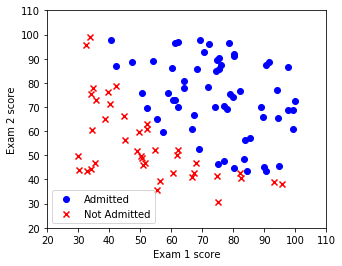

[ Iteration 25 ] cost = 0.592109242119


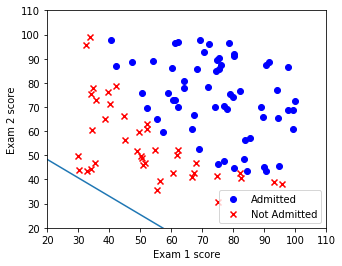

[ Iteration 50 ] cost = 0.545925428175


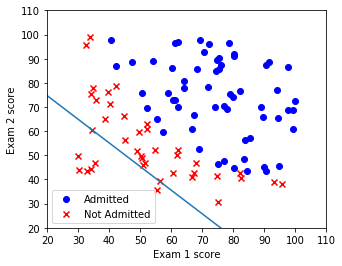

[ Iteration 75 ] cost = 0.50863058216


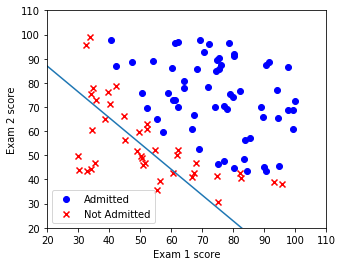

[ Iteration 100 ] cost = 0.4781475877


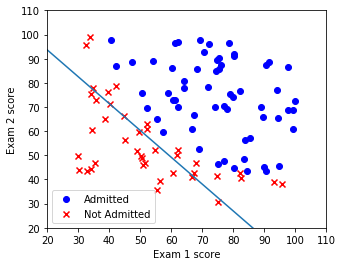

[ Iteration 125 ] cost = 0.452905283431


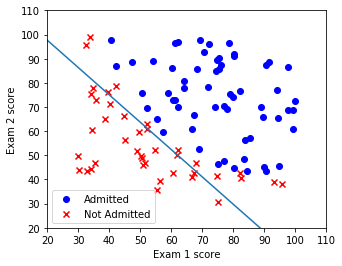

[ Iteration 150 ] cost = 0.431731946504


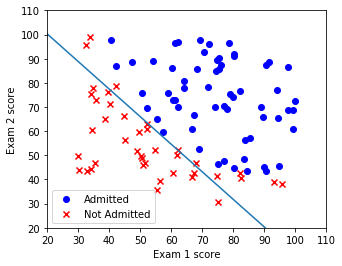

[ Iteration 175 ] cost = 0.413755052046


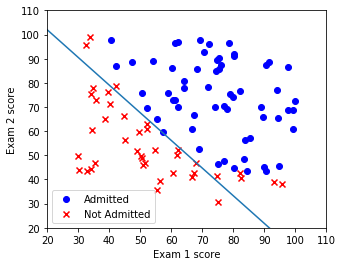

[ Iteration 200 ] cost = 0.398321105807


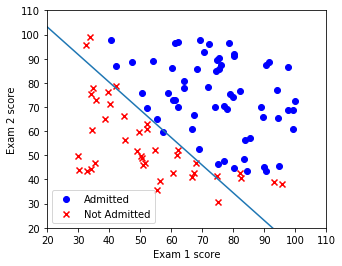

[ Iteration 225 ] cost = 0.38493590527


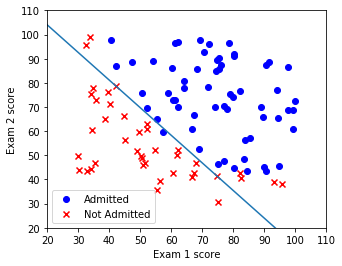

[ Iteration 250 ] cost = 0.373221389229


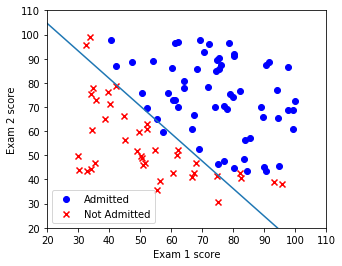

[ Iteration 275 ] cost = 0.362884816556


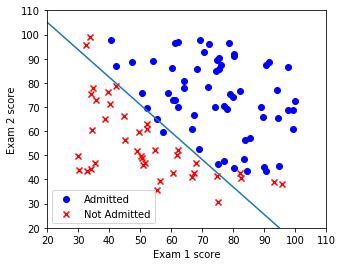

[ Iteration 300 ] cost = 0.353696760907


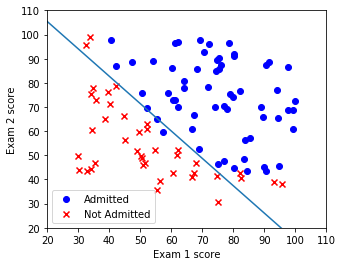

[ Iteration 325 ] cost = 0.345475313353


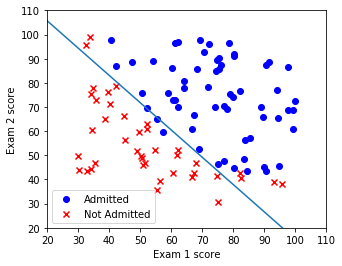

[ Iteration 350 ] cost = 0.338074642847


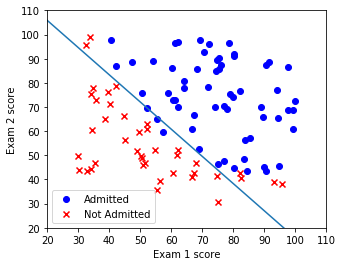

[ Iteration 375 ] cost = 0.331376626745


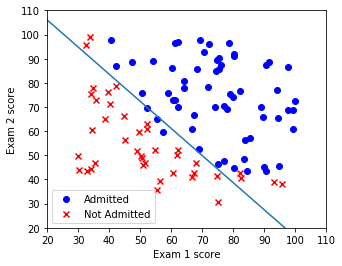

[ Iteration 400 ] cost = 0.325284659974


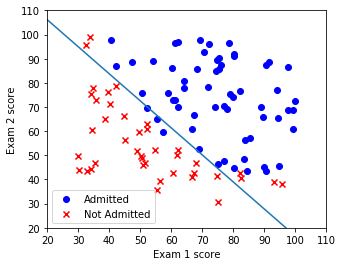

In [10]:
def gradient_descent(theta, X, y, alpha=1e-2, max_iterations=400):
    """ 
    Batch gradient descent algorithm.
    Update the parameter 'theta' iteratively to minimize the cost.
    """
 
    alpha *= X.shape[0]
    iteration = 0
    
    """
    To avoid repeat caculation, the following two steps should be outside 
    the 'gradient_decent' function. However, we do them here because it will be easier 
    to visualize the decision boundary next. 
    1. Scaling
    2. Adding a bias term.
    """
    
    scaledX = X / np.max(np.absolute(X), axis=0, keepdims=True)
    X = np.insert(X, 2, 1, axis=1)
    scaledX = np.insert(scaledX, 2, 1, axis=1)

    while(iteration < max_iterations):
        iteration += 1
        
        # Simultaneous update of partial gradients
        
        theta = theta - alpha * gradient_update(theta, scaledX, y)
        
        # For every few iterations
        if iteration % 25 == 0 or iteration == 1:

            cost = cost_function(theta, scaledX, y)
                        
            print ("[ Iteration", iteration, "]", "cost =", cost)
            
            plt.rcParams['figure.figsize'] = (5.0, 4.0)
            plt.xlim([20,110])
            plt.ylim([20,110])
            
            pos = np.where(y == 1)
            neg = np.where(y == 0)
            
            plt.scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
            plt.scatter(X[neg, 0], X[neg, 1], marker='x', c='r')
            plt.xlabel('Exam 1 score')
            plt.ylabel('Exam 2 score')
            plt.legend(['Admitted', 'Not Admitted'])
            t = np.arange(10, 100, 0.1)
            
            """
            Plotting the decision boundary. Since we've scaled our features, 
            we must scale back while plotting.
            Scaling by 100 which is the maximum value attainable by a data point.
            """            
            
            yy = (-1 * theta[2] / theta[1]) + (-1 * (theta[0] / theta[1]) * t) / 100
            yy *= 100
            
            plt.plot(t, yy)
                        
            plt.show()
               
    return theta


# Initializing the parameters 'theta' to some random values.

initial_theta = np.random.randn(train_X.shape[1] + 1)

learned_theta = gradient_descent(initial_theta, train_X, train_y)

## 7. Predicting 
Now that the parameters of the model are learned, we can use the model to prdict whether a particular student will be admited. The 'predict' function should output the probabilities of being classified as positive. 

In [11]:
def predict(theta, X):
    """ 
    Predict whether the label is 0 or 1 using learned logistic regression parameters.
    We must do the exact same feature scaling for predicting as well.
    """
    
    scaledX = X / np.max(np.absolute(X), axis=0, keepdims=True)
    scaledX = np.insert(scaledX, 2, 1, axis=1)
    probabilities = sigmoid(scaledX.dot(theta))
    predicted_labels = np.empty(len(probabilities))
    predicted_labels[np.where(probabilities >= 0.5)] = 1
    predicted_labels[np.where(probabilities < 0.5)] = 0
    
    return probabilities, 1 * predicted_labels 

# Quick check for the predict function.
t_X1 = [[90, 90]]
t_X2 = [[50, 60]]
t_X3 = [[50, 50]]
print (predict(learned_theta, t_X1))
print (predict(learned_theta, t_X2))
print (predict(learned_theta, t_X3))

# Compute accuracy on the training dataset.
t_prob, t_label = predict(learned_theta, train_X)
t_precision = t_label[np.where(t_label == train_y)].size / float(train_y.size) * 100
print('Accuracy on the training set: %s%%' % round(t_precision,2))

(array([ 0.9899428]), array([ 1.]))
(array([ 0.9899428]), array([ 1.]))
(array([ 0.9899428]), array([ 1.]))
Accuracy on the training set: 92.0%
